Creating augmentation visualization (3 samples, 4 augmentations each)...


/tmp/ipykernel_3879663/1851696512.py:33: UserWarning: Argument(s) 'variance_limit' are not valid for transform GaussNoise
  A.GaussNoise(variance_limit=(10, 50), p=0.3),  # Fixed parameter name


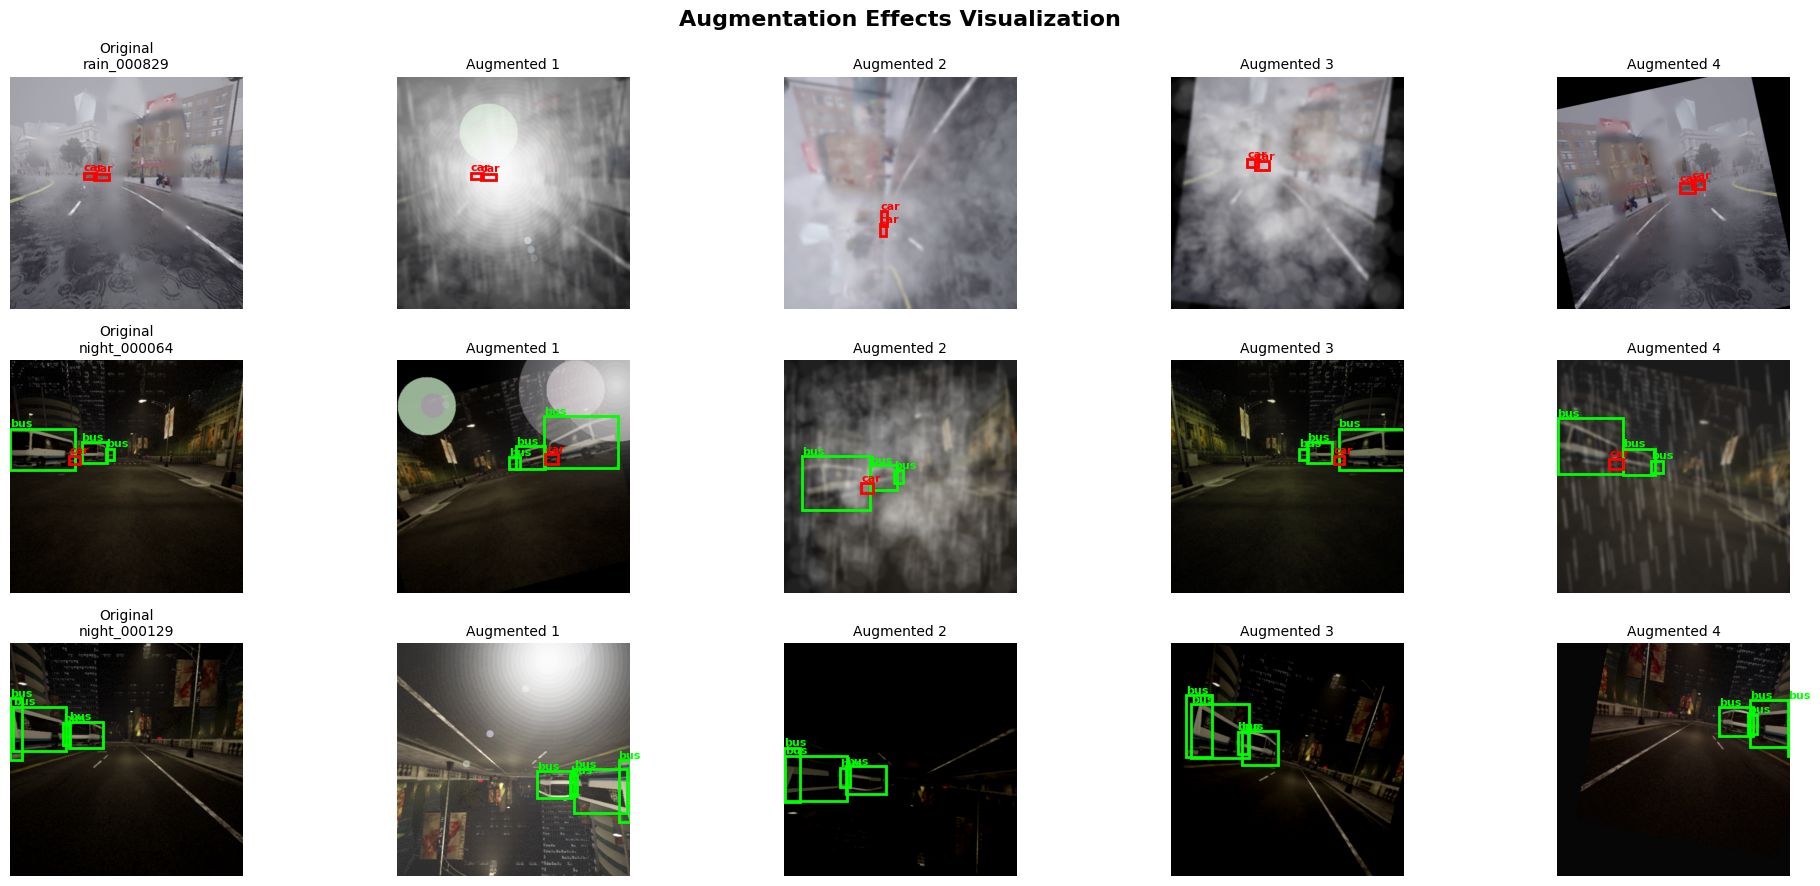

Augmentation visualization saved: yolo_dataset/analysis/augmentation_visualization.png
Creating individual augmentation effects visualization...


/tmp/ipykernel_3879663/1851696512.py:202: UserWarning: Argument(s) 'variance_limit' are not valid for transform GaussNoise
  'Gaussian Noise': A.GaussNoise(variance_limit=(20, 80), p=1.0),


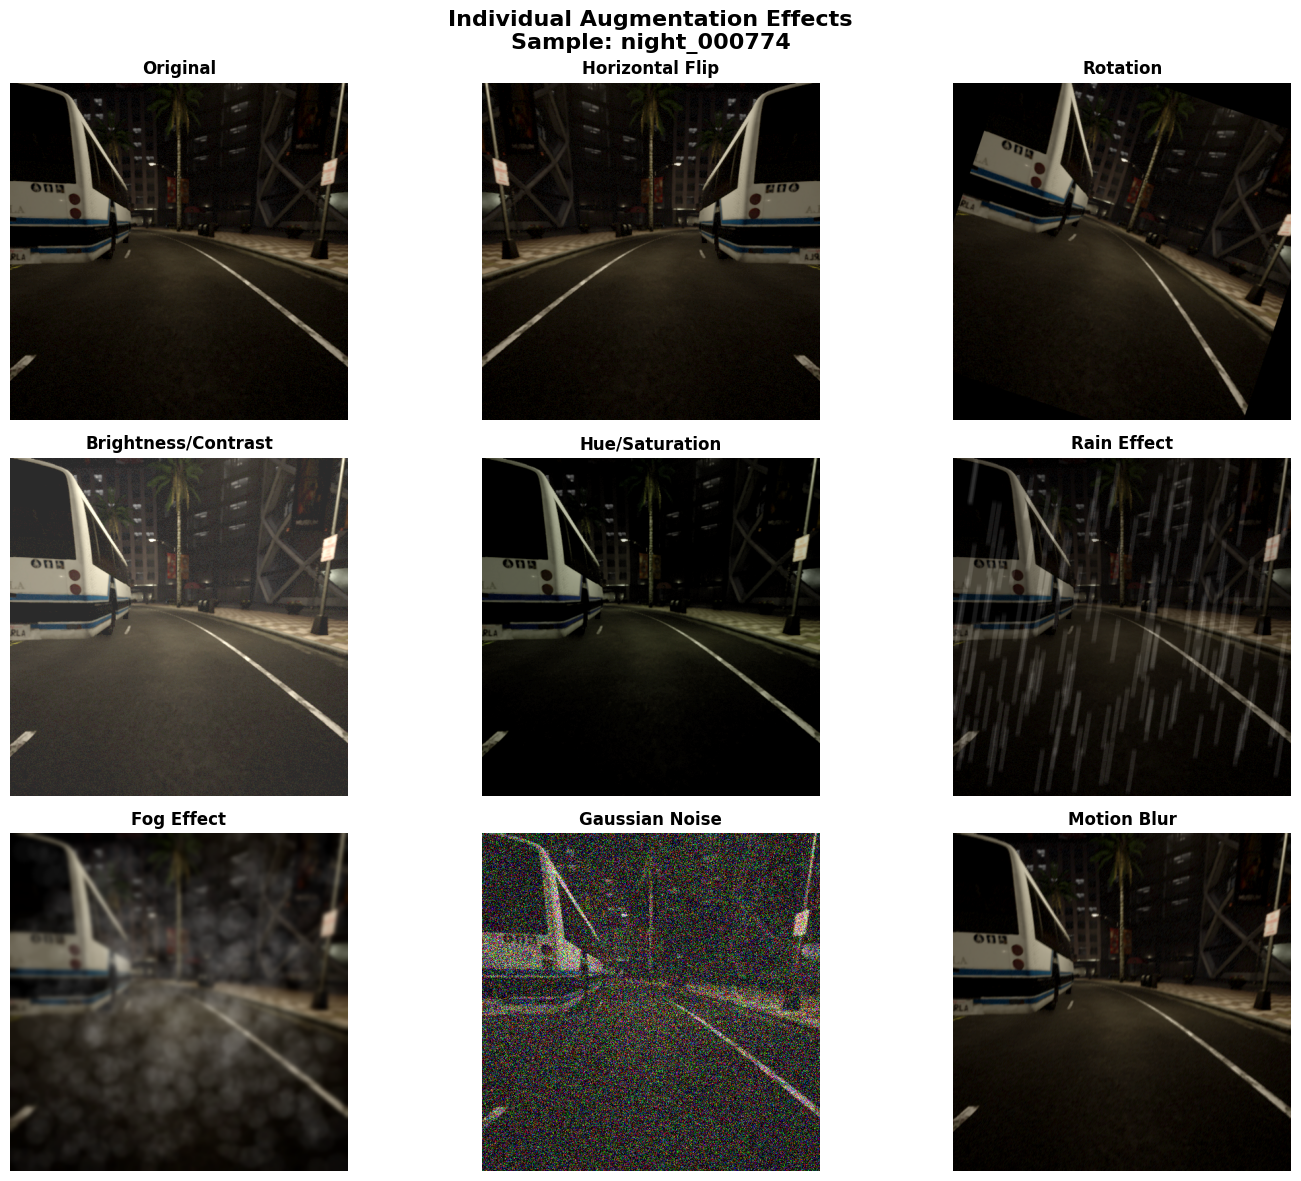

Individual augmentation visualization saved: yolo_dataset/analysis/individual_augmentations.png
Creating augmentation intensity visualization...


/tmp/ipykernel_3879663/1851696512.py:289: UserWarning: Argument(s) 'variance_limit' are not valid for transform GaussNoise
  'Noise': lambda p: A.GaussNoise(variance_limit=(10, p*100), p=1.0),


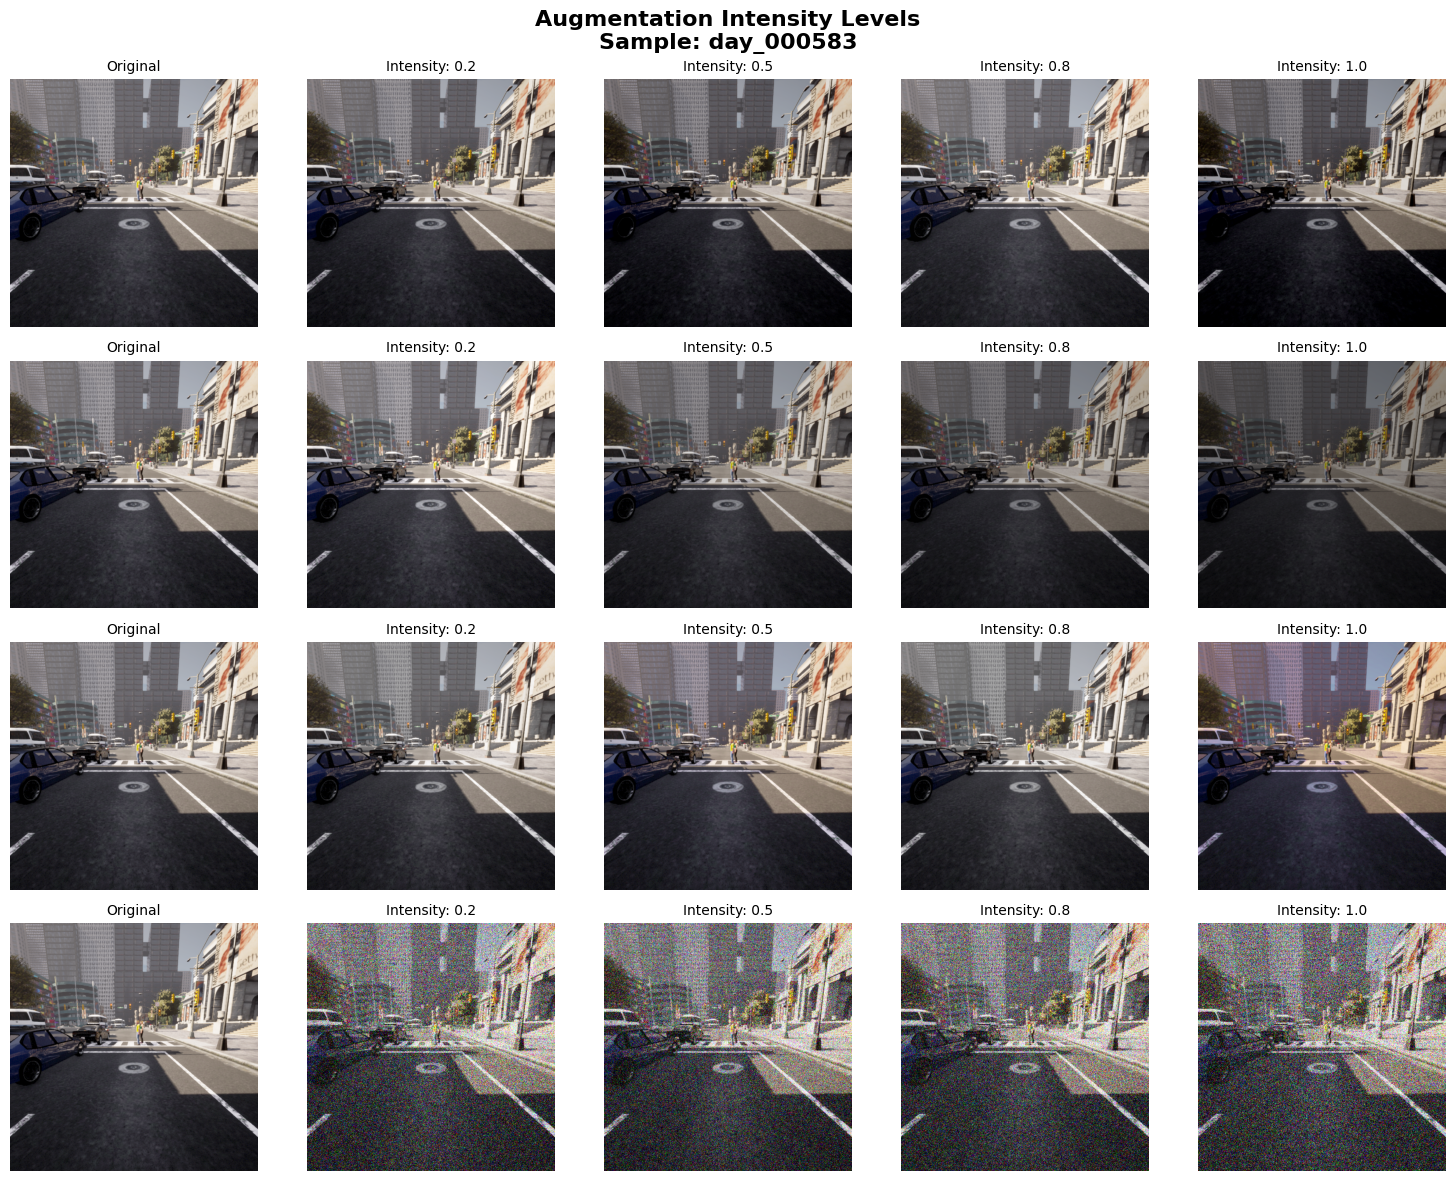

Augmentation intensity visualization saved: yolo_dataset/analysis/augmentation_intensity.png


In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import random
from pathlib import Path
import albumentations as A
from PIL import Image
import json
from yolo_data_preprocessor_3 import YOLOv11DataPreprocessor

def visualize_augmentation_effects(preprocessor, num_samples=6, num_augmentations=4):
    """
    Visualize the effects of the augmentation pipeline on sample images
    
    Args:
        preprocessor: YOLOv11DataPreprocessor instance
        num_samples: Number of original images to show
        num_augmentations: Number of augmented versions per image
    """
    print(f"Creating augmentation visualization ({num_samples} samples, {num_augmentations} augmentations each)...")
    
    # Create augmentation pipeline with proper bbox_params
    aug_pipeline = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
        A.RandomRain(p=0.3),
        A.RandomFog(p=0.3),
        A.RandomSunFlare(p=0.2),
        A.GaussNoise(variance_limit=(10, 50), p=0.3),  # Fixed parameter name
        A.MotionBlur(blur_limit=3, p=0.2),
        A.GaussianBlur(blur_limit=3, p=0.2),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    # Get sample images from train set
    train_images_dir = preprocessor.output_path / "train" / "images"
    train_labels_dir = preprocessor.output_path / "train" / "labels"
    
    image_files = list(train_images_dir.glob("*.png"))
    if len(image_files) < num_samples:
        num_samples = len(image_files)
        print(f"Only {num_samples} samples available")
    
    selected_files = random.sample(image_files, num_samples)
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, num_augmentations + 1, 
                            figsize=((num_augmentations + 1) * 4, num_samples * 3))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Augmentation Effects Visualization', fontsize=16, fontweight='bold')
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # RGB colors
    class_names = preprocessor.class_names
    
    for row, image_file in enumerate(selected_files):
        try:
            # Load original image
            image = cv2.imread(str(image_file))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w = image.shape[:2]
            
            # Load annotations
            label_file = train_labels_dir / f"{image_file.stem}.txt"
            bboxes = []
            class_labels = []
            
            if label_file.exists():
                with open(label_file, 'r') as f:
                    annotations = f.readlines()
                
                for annotation in annotations:
                    parts = annotation.strip().split()
                    # if len(parts) < 7:
                    #     continue
                    
                    class_id = int(parts[0])
                    coords = [float(x) for x in parts[1:]]
                    
                    # Convert polygon to bounding box for augmentation
                    x_coords = coords[::2]
                    y_coords = coords[1::2]
                    
                    x_min, x_max = min(x_coords), max(x_coords)
                    y_min, y_max = min(y_coords), max(y_coords)
                    
                    # Store in YOLO format (center_x, center_y, width, height)
                    center_x = (x_min + x_max) / 2
                    center_y = (y_min + y_max) / 2
                    width = x_max - x_min
                    height = y_max - y_min
                    
                    bboxes.append([center_x, center_y, width, height])
                    class_labels.append(class_id)
            
            # Show original image
            axes[row, 0].imshow(image)
            axes[row, 0].set_title(f'Original\n{image_file.stem}', fontsize=10)
            axes[row, 0].axis('off')
            
            # Draw original annotations
            for bbox, class_id in zip(bboxes, class_labels):
                class_id=int(class_id)
                center_x, center_y, width, height = bbox
                x_min = (center_x - width/2) * w
                y_min = (center_y - height/2) * h
                width_px = width * w
                height_px = height * h
                
                color = [c/255.0 for c in colors[int(class_id % len(colors))]]
                rect = patches.Rectangle((x_min, y_min), width_px, height_px,
                                       linewidth=2, edgecolor=color, facecolor='none')
                axes[row, 0].add_patch(rect)
                
                # Add class label
                axes[row, 0].text(x_min, y_min-5, class_names[class_id], 
                                color=color, fontsize=8, fontweight='bold')
            
            # Apply augmentations
            for col in range(1, num_augmentations + 1):
                try:
                    # Apply augmentation
                    if len(bboxes) > 0:
                        augmented = aug_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
                        aug_image = augmented['image']
                        aug_bboxes = augmented['bboxes']
                        aug_class_labels = augmented['class_labels']
                    else:
                        # If no bboxes, just augment the image
                        augmented = aug_pipeline(image=image, bboxes=[], class_labels=[])
                        aug_image = augmented['image']
                        aug_bboxes = []
                        aug_class_labels = []
                    
                    # Show augmented image
                    axes[row, col].imshow(aug_image)
                    axes[row, col].set_title(f'Augmented {col}', fontsize=10)
                    axes[row, col].axis('off')
                    
                    # Draw augmented annotations
                    for bbox, class_id in zip(aug_bboxes, aug_class_labels):
                        center_x, center_y, width, height = bbox
                        x_min = (center_x - width/2) * w
                        y_min = (center_y - height/2) * h
                        width_px = width * w
                        height_px = height * h
                        
                        color = [c/255.0 for c in colors[int(class_id % len(colors))]]
                        rect = patches.Rectangle((x_min, y_min), width_px, height_px,
                                               linewidth=2, edgecolor=color, facecolor='none')
                        axes[row, col].add_patch(rect)
                        
                        # Add class label
                        axes[row, col].text(x_min, y_min-5, class_names[int(class_id)], 
                                          color=color, fontsize=8, fontweight='bold')
                
                except Exception as e:
                    raise
                    # print(f"Error applying augmentation {col} to {image_file.stem}: {e}")
                    # axes[row, col].text(0.5, 0.5, f'Aug Error\n{str(e)[:20]}...', 
                    #                   ha='center', va='center', transform=axes[row, col].transAxes)
                    # axes[row, col].axis('off')
        
        except Exception as e:
            raise
            print(f"Error processing {image_file}: {e}")
            for col in range(num_augmentations + 1):
                axes[row, col].text(0.5, 0.5, f'Error\n{str(e)[:20]}...', 
                                  ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = preprocessor.output_path / "analysis" / "augmentation_visualization.png"
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Augmentation visualization saved: {viz_path}")


def visualize_individual_augmentations(preprocessor, sample_image_path=None):
    """
    Visualize individual augmentation effects separately (image only, no bboxes)
    """
    print("Creating individual augmentation effects visualization...")
    
    # Individual augmentations to showcase (without bbox transforms)
    augmentations = {
        'Original': None,
        'Horizontal Flip': A.HorizontalFlip(p=1.0),
        'Rotation': A.Rotate(limit=30, p=1.0),
        'Brightness/Contrast': A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
        'Hue/Saturation': A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),
        'Rain Effect': A.RandomRain(p=1.0),
        'Fog Effect': A.RandomFog(p=1.0),
        'Gaussian Noise': A.GaussNoise(variance_limit=(20, 80), p=1.0),
        'Motion Blur': A.MotionBlur(blur_limit=7, p=1.0),
    }
    
    # Get a sample image
    if sample_image_path is None:
        train_images_dir = preprocessor.output_path / "train" / "images"
        image_files = list(train_images_dir.glob("*.png"))
        sample_image_path = random.choice(image_files)
    
    # Load image
    image = cv2.imread(str(sample_image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create visualization
    cols = 3
    rows = (len(augmentations) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    fig.suptitle(f'Individual Augmentation Effects\nSample: {Path(sample_image_path).stem}', 
                 fontsize=16, fontweight='bold')
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (aug_name, augmentation) in enumerate(augmentations.items()):
        row = idx // cols
        col = idx % cols
        
        try:
            if augmentation is None:
                # Show original
                aug_image = image
            else:
                # Apply augmentation
                augmented = augmentation(image=image)
                aug_image = augmented['image']
            
            axes[row, col].imshow(aug_image)
            axes[row, col].set_title(aug_name, fontsize=12, fontweight='bold')
            axes[row, col].axis('off')
            
        except Exception as e:
            print(f"Error applying {aug_name}: {e}")
            axes[row, col].text(0.5, 0.5, f'Error\n{aug_name}', 
                              ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    # Hide unused subplots
    for idx in range(len(augmentations), rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = preprocessor.output_path / "analysis" / "individual_augmentations.png"
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Individual augmentation visualization saved: {viz_path}")


def visualize_augmentation_intensity(preprocessor, sample_image_path=None):
    """
    Visualize different intensity levels of augmentations
    """
    print("Creating augmentation intensity visualization...")
    
    # Get a sample image
    if sample_image_path is None:
        train_images_dir = preprocessor.output_path / "train" / "images"
        image_files = list(train_images_dir.glob("*.png"))
        sample_image_path = random.choice(image_files)
    
    # Load image
    image = cv2.imread(str(sample_image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Different intensity levels
    intensities = [0.2, 0.5, 0.8, 1.0]
    
    augmentations = {
        'Brightness': lambda p: A.RandomBrightnessContrast(brightness_limit=p*0.4, contrast_limit=0, p=1.0),
        'Contrast': lambda p: A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=p*0.4, p=1.0),
        'Saturation': lambda p: A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=p*40, val_shift_limit=0, p=1.0),
        'Noise': lambda p: A.GaussNoise(variance_limit=(10, p*100), p=1.0),
    }
    
    fig, axes = plt.subplots(len(augmentations), len(intensities) + 1, 
                            figsize=((len(intensities) + 1) * 3, len(augmentations) * 3))
    
    fig.suptitle(f'Augmentation Intensity Levels\nSample: {Path(sample_image_path).stem}', 
                 fontsize=16, fontweight='bold')
    
    for row, (aug_name, aug_func) in enumerate(augmentations.items()):
        # Show original
        axes[row, 0].imshow(image)
        axes[row, 0].set_title('Original', fontsize=10)
        axes[row, 0].set_ylabel(aug_name, fontsize=12, fontweight='bold')
        axes[row, 0].axis('off')
        
        # Show different intensities
        for col, intensity in enumerate(intensities, 1):
            try:
                augmentation = aug_func(intensity)
                augmented = augmentation(image=image)
                aug_image = augmented['image']
                
                axes[row, col].imshow(aug_image)
                axes[row, col].set_title(f'Intensity: {intensity}', fontsize=10)
                axes[row, col].axis('off')
                
            except Exception as e:
                print(f"Error applying {aug_name} at intensity {intensity}: {e}")
                axes[row, col].text(0.5, 0.5, f'Error', 
                                  ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = preprocessor.output_path / "analysis" / "augmentation_intensity.png"
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Augmentation intensity visualization saved: {viz_path}")


# Simplified version that works with your current setup
def quick_augmentation_demo(dataset_path="yolo_dataset"):
    """
    Quick demo for existing converted dataset
    """
    # Create a minimal preprocessor instance just for visualization
    class MinimalPreprocessor:
        def __init__(self, output_path):
            self.output_path = Path(output_path)
            self.class_names = ["car", "bus", "pedestrian", "traffic_light"]
    
    preprocessor = MinimalPreprocessor(dataset_path)
    
    # Make sure analysis directory exists
    (preprocessor.output_path / "analysis").mkdir(parents=True, exist_ok=True)
    
    # Run visualizations
    try:
        visualize_augmentation_effects(preprocessor, num_samples=3, num_augmentations=4)
    except Exception as e:
        raise
        # print(f"Error in augmentation effects visualization: {e}")
    
    try:
        visualize_individual_augmentations(preprocessor)
    except Exception as e:
        # print(f"Error in individual augmentations visualization: {e}")
        raise    
    try:
        visualize_augmentation_intensity(preprocessor)
    except Exception as e:
        raise
        # print(f"Error in augmentation intensity visualization: {e}")

# Run the demo
if __name__ == "__main__":
    quick_augmentation_demo("yolo_dataset")
